### Packages import

In [1]:
# Import base packages
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Import DL packages
import tensorflow as tf
print(f'TensorFlow version: {tf.__version__}')
print(f'Keras version: {tf.keras.__version__}')
import tensorflow_hub as hub
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

TensorFlow version: 2.3.1
Keras version: 2.4.0


In [2]:
pip install --upgrade tensorflow 

     |████████████████████████████████| 320.4MB 54kB/s s eta 0:00:01    |████▋                           | 46.3MB 13.8MB/s eta 0:00:20     |████▊                           | 47.3MB 19.9MB/s eta 0:00:14     |███████▍                        | 74.3MB 9.7MB/s eta 0:00:26     |████████▉                       | 88.2MB 16.9MB/s eta 0:00:14     |█████████▏                      | 91.7MB 16.9MB/s eta 0:00:14     |██████████                      | 99.7MB 16.9MB/s eta 0:00:14     |██████████▍                     | 104.0MB 15.7MB/s eta 0:00:14     |███████████▍                    | 113.9MB 15.7MB/s eta 0:00:14     |███████████▌                    | 115.7MB 15.7MB/s eta 0:00:14     |████████████▍                   | 124.1MB 16.8MB/s eta 0:00:12     |████████████▌                   | 125.0MB 16.8MB/s eta 0:00:12     |█████████████▎                  | 133.0MB 16.8MB/s eta 0:00:12     |█████████████▉                  | 138.4MB 24.0MB/s eta 0:00:08████▎                | 153.2MB 9.1MB/s eta 0:00:19     |

  Found existing installation: gast 0.2.2
    Uninstalling gast-0.2.2:
      Successfully uninstalled gast-0.2.2
  Found existing installation: h5py 2.9.0
    Uninstalling h5py-2.9.0:
      Successfully uninstalled h5py-2.9.0
  Found existing installation: tensorflow-estimator 2.0.1
    Uninstalling tensorflow-estimator-2.0.1:
      Successfully uninstalled tensorflow-estimator-2.0.1
  Found existing installation: tensorboard 2.1.1
    Uninstalling tensorboard-2.1.1:
      Successfully uninstalled tensorboard-2.1.1
  Found existing installation: tensorflow 2.0.1
    Uninstalling tensorflow-2.0.1:
      Successfully uninstalled tensorflow-2.0.1
Note: you may need to restart the kernel to use updated packages.


### Read train/test datasets
Create a function to read train and test datasets with follow actions:
- Have a look at readme.txt from the unzipped folder to get more information about the datasets
- Columns should be renamed to 'rate' and 'text'
- Take a random sample of 5000 records for training and test datasets
- Positive labels should be mapped to 0 (instead of 2 in the initial dataset)

In [2]:
def read_format_dataset(dataset_path):
    fulldata = pd.read_csv(dataset_path, header=0, names=['rate', 'text'])
    fulldata['rate'] = fulldata['rate'] - 1
    
    return fulldata.sample(5000)

train_dataset_path = './Data/train.csv'
test_dataset_path = './Data/test.csv'
train_data = read_format_dataset(train_dataset_path)
test_data = read_format_dataset(test_dataset_path)
train_data.head()

,rate,text
268392,0,it has been a while since I visited Press. Ne...
31182,0,I've been looking for a good Hawaiian place si...
53853,1,This is my go to AYCE Korean BBQ. Their meat i...
344367,1,I would honestly give this 3.5 stars. We've on...
527252,1,Samantha has been doing my hair since the Giso...


### Define your Keras model using Transfer Learning (sans ré-entraîner les poids)
Now you should define your NN structure using Keras sequential layers. Your base model will come from TensorFlow Hub with source url https://tfhub.dev/google/universal-sentence-encoder/4.
To import this base model in your structure, you must use hub.KerasLayer function (https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer). You should add following parameters:
- input_shape = []
- dtype = tf.string
- trainable = False

Please note this trainable option that allows to retrain the entire NN or not.

Now that you have your base model, you should add a new layer on top to predict a probability for our 2 classes (Positive/Negative). Which layer would you use for this ? Which activation function ?

Your final model should have two layers:
- base model with 256797824 params
- prediction layer with 513 params

Please have a look at the number of training params and its relation with base model option trainable.

In [3]:
base_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [4]:
test = base_model(["what's up dude"])
print(test.shape)
print(test[0][:5])

(1, 512)
tf.Tensor([-0.01453453  0.01348065  0.04381655  0.02397885  0.01832271], shape=(5,), dtype=float32)


In [150]:
model = Sequential([
    hub.KerasLayer(
        base_model,
        trainable=False,
        input_shape=[],
        dtype=tf.string
    ),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_28 (KerasLayer)  (None, 512)               256797824 
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 513       
Total params: 256,798,337
Trainable params: 513
Non-trainable params: 256,797,824
_________________________________________________________________


#### Model compiler
Compile your Keras model using an Adam optimizer, binary crossentropy for the loss and accuracy as the target metric

In [151]:
model.compile(
    optimizer="adam",
    loss='binary_crossentropy',
    metrics=['accuracy']
)

#### Model training
Split your training data into x_train, x_valid, y_train, y_valid using sklearn function. Test size must be set to 0.3 and the repartition of the target variable should be similar between your valid and training samples.

In [5]:
RANDOM_SEED = 15

In [6]:
x_train, x_valid, y_train, y_valid = train_test_split(
    train_data["text"], train_data["rate"],
    test_size=0.3, random_state=RANDOM_SEED
)
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)

(3500,)
(3500,)
(1500,)
(1500,)


In [154]:
x_valid[:5]

153760    well, if you're two girls going to Tao, it's c...
285915    La Maison du Jazz est un restaurant o\u00f9 il...
548978    Great craft beer menu, one of the better selec...
32438     Gross.  Typical greasy, low quality Mexican fo...
20091     I went to this Fry's on Friday the 1/24/14 and...
Name: text, dtype: object

Now you can train your NN by providing your training and valid datasets. Number of epochs can be set to 5 for now. You need to save the model fit output into history variable, so we can plot the loss later.

In [155]:
history = model.fit(
    x=x_train.values,
    y=y_train.values,
    batch_size=None,
    epochs=5,
    verbose=1,
    validation_data=(x_valid.values, y_valid.values),
    workers=0
)

Train on 3500 samples, validate on 1500 samples
Epoch 1/5
3500/3500 [==============================] - 8s 2ms/sample - loss: 0.6676 - accuracy: 0.7397 - val_loss: 0.6385 - val_accuracy: 0.8080
Epoch 2/5
3500/3500 [==============================] - 5s 1ms/sample - loss: 0.6168 - accuracy: 0.8354 - val_loss: 0.5917 - val_accuracy: 0.8480
Epoch 3/5
3500/3500 [==============================] - 5s 1ms/sample - loss: 0.5749 - accuracy: 0.8437 - val_loss: 0.5530 - val_accuracy: 0.8647
Epoch 4/5
3500/3500 [==============================] - 5s 1ms/sample - loss: 0.5402 - accuracy: 0.8511 - val_loss: 0.5205 - val_accuracy: 0.8720
Epoch 5/5
3500/3500 [==============================] - 5s 1ms/sample - loss: 0.5108 - accuracy: 0.8554 - val_loss: 0.4935 - val_accuracy: 0.8740


#### Train/validation error history
You can plot the training/validation error and accuracy using the following function.

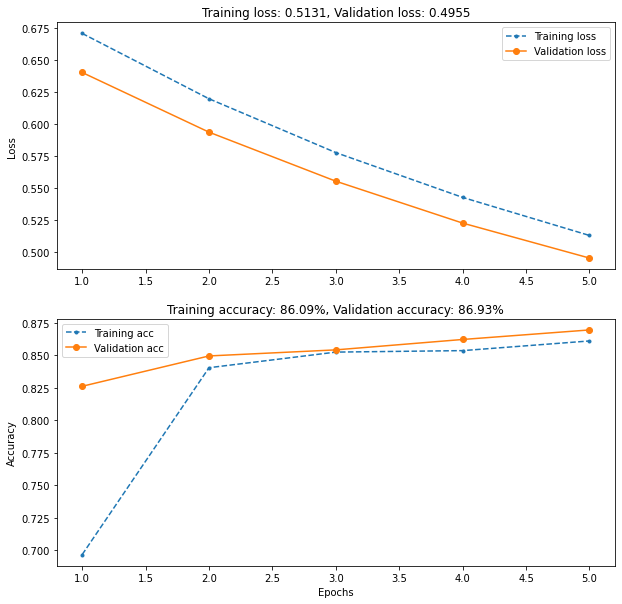

In [124]:
def plot_loss_acc(history):
    """Plot training and (optionally) validation loss and accuracy"""

    loss = history.history['loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(10, 10))

    plt.subplot(2, 1, 1)
    plt.plot(epochs, loss, '.--', label='Training loss')
    final_loss = loss[-1]
    title = 'Training loss: {:.4f}'.format(final_loss)
    plt.ylabel('Loss')
    if 'val_loss' in history.history:
        val_loss = history.history['val_loss']
        plt.plot(epochs, val_loss, 'o-', label='Validation loss')
        final_val_loss = val_loss[-1]
        title += ', Validation loss: {:.4f}'.format(final_val_loss)
    plt.title(title)
    plt.legend()

    acc = history.history['accuracy']

    plt.subplot(2, 1, 2)
    plt.plot(epochs, acc, '.--', label='Training acc')
    final_acc = acc[-1]
    title = 'Training accuracy: {:.2f}%'.format(final_acc * 100)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    if 'val_accuracy' in history.history:
        val_acc = history.history['val_accuracy']
        plt.plot(epochs, val_acc, 'o-', label='Validation acc')
        final_val_acc = val_acc[-1]
        title += ', Validation accuracy: {:.2f}%'.format(final_val_acc * 100)
    plt.title(title)
    plt.legend()

plot_loss_acc(history)

#### Performance on test dataset
Compute the accuracy for our test dataset

In [125]:
y_pred[:3]

array([[0.52996373],
       [0.3027997 ],
       [0.6187022 ]], dtype=float32)

In [126]:
y_pred_binaire = [0 if value<0.5 else 1 for value in y_pred]
y_pred_binaire[:3]

[1, 0, 1]

In [17]:
y_pred = model.predict_class(test_data["text"].values)
acc = accuracy_score(test_data["rate"].values, y_pred_binaire)
print(acc)

NameError: name 'model' is not defined

#### 1st interpretation
Apart from the final precision, what do you think about the training/validation curves ? Is there any evidence of overfitting when we freeze the base layer ?

Now, you can go back to the model definition and unfreeze our base layers. You should see the difference with the number of trainable parameters. No other parameters should be updated. Obviously training your model will take longer.

### transfer learning avec ré-entraînement des poids

In [7]:
model2 = Sequential([
    hub.KerasLayer(
        base_model,
        trainable=True,
        input_shape=[],
        dtype=tf.string
    ),
    Dense(1, activation='sigmoid')
])

model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 512)               256797824 
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 256,798,337
Trainable params: 256,798,337
Non-trainable params: 0
_________________________________________________________________


#### Model compiler
Compile your Keras model using an Adam optimizer, binary crossentropy for the loss and accuracy as the target metric

In [8]:
model2.compile(
    optimizer="adam",
    loss='binary_crossentropy',
    metrics=['accuracy']
)

#### Model training
Split your training data into x_train, x_valid, y_train, y_valid using sklearn function. Test size must be set to 0.3 and the repartition of the target variable should be similar between your valid and training samples.

Now you can train your NN by providing your training and valid datasets. Number of epochs can be set to 5 for now. You need to save the model fit output into history variable, so we can plot the loss later.

In [9]:
history2 = model2.fit(
    x=np.asarray(x_train),
    y=np.asarray(y_train),
    batch_size=None,
    epochs=5,
    verbose=1,
    validation_data=(np.asarray(x_valid), np.asarray(y_valid)),
    workers=0
)

Epoch 1/5
110/110 [==============================] - 309s 3s/step - loss: 0.4332 - accuracy: 0.8166 - val_loss: 0.3048 - val_accuracy: 0.8853
Epoch 2/5
110/110 [==============================] - 294s 3s/step - loss: 0.1152 - accuracy: 0.9709 - val_loss: 0.2104 - val_accuracy: 0.9187
Epoch 3/5
110/110 [==============================] - 301s 3s/step - loss: 0.0283 - accuracy: 0.9974 - val_loss: 0.2506 - val_accuracy: 0.9180
Epoch 4/5
110/110 [==============================] - 325s 3s/step - loss: 0.0112 - accuracy: 0.9997 - val_loss: 0.2762 - val_accuracy: 0.9000
Epoch 5/5
110/110 [==============================] - 320s 3s/step - loss: 0.0071 - accuracy: 1.0000 - val_loss: 0.2573 - val_accuracy: 0.9160


#### Train/validation error history
You can plot the training/validation error and accuracy using the following function.

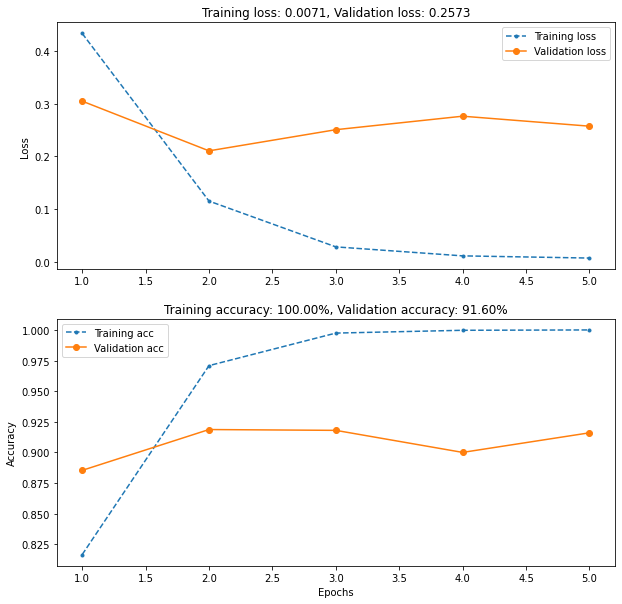

In [12]:
plot_loss_acc(history2)

#### Performance on test dataset
Compute the accuracy for our test dataset

In [14]:
y_pred = model2.predict(test_data["text"].values)
y_pred[:3]

array([[0.0319134 ],
       [0.9599415 ],
       [0.00583929]], dtype=float32)

In [15]:
y_pred_binaire = [0 if value<0.5 else 1 for value in y_pred]
y_pred_binaire[:3]

[0, 1, 0]

In [16]:
acc = accuracy_score(test_data["rate"].values, y_pred_binaire)
print(acc)

0.9164


#### 2nd interpretation

What do you notice now with our training/validation curves? Do you have any hints about why we observe such results ?

You need to find a way to solve this problem. Please go back to the model definition and try to add new type of layer.